In [1]:
import time
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Using TensorFlow backend.


In [2]:
filename = 'TrainEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_train = data

filename = 'TestEOB_q-1-10-0.02_ProperWhitenZ.h5'
f = h5py.File(filename, 'r')
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])
y_test = data

print("Number of Training Waves: " + str(len(y_train)))
print("Number of Testing Waves: " + str(len(y_test)))

Number of Training Waves: 9861
Number of Testing Waves: 2459


In [3]:
# Add noise

x_train = []
for i in range(len(y_train)):
    snr_inverse = 0.66666666
    noise = snr_inverse * np.random.normal(0,1,8192)
    
    x_train.append(y_train[i] + noise)
    
x_test = []
for i in range(len(y_test)):
    snr_inverse = 0.66666666
    noise = snr_inverse * np.random.normal(0,1,8192)
    
    x_test.append(y_test[i] + noise)
    

In [4]:
# Data Processing

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Adding an extra dimension as Keras LSTM layers take in a NumPy array of 3 dimensions
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Sample Wave from Training Set:


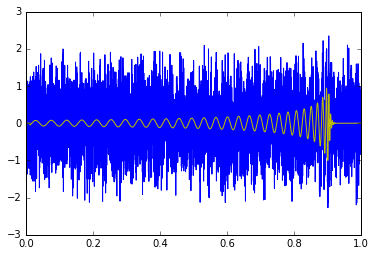

Sample Wave from Test Set:


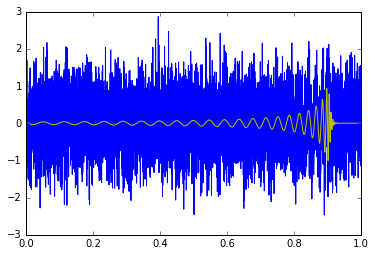

In [5]:
t = np.linspace(0, 1, 8192)

print("Sample Wave from Training Set:")
plt.plot(t, x_train[1451], "b-")
plt.plot(t, y_train[1451], "y-")
plt.show()

print("Sample Wave from Test Set:")
plt.plot(t, x_test[1451], "b-")
plt.plot(t, y_test[1451], "y-")
plt.show()

In [6]:
def build_model(layers):
    
    model = Sequential()
    
    model.add(LSTM(input_dim = layers[0], output_dim = layers[1], return_sequences = True))
    # model.add(Dropout(0.2))
    
    model.add(LSTM(layers[2], return_sequences = True))
    # model.add(Dropout(0.2))
    
    model.add(LSTM(layers[3], return_sequences = True))
    # model.add(Dropout(0.2))
    
    model.add(LSTM(layers[4], return_sequences = False))
    # model.add(Dropout(0.2))
    
    model.add(Dense(output_dim = layers[5]))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    # try changing whether there is dropout, activation function, loss function, number of layers, in/out of layers
    
    return model

In [7]:
epochs = 1
global_start_time = time.time()

model = build_model([1, 256, 256, 256, 256, 8192])

# model.load_weights('rnn_weights_1.h5')

model.fit(x_train,
          y_train,
          batch_size=64,
          nb_epoch=epochs,
          validation_split=0)

predicted = model.predict(x_test)

print(" ")
print('Training duration (min) : ', (time.time() - global_start_time)/60)

model.save_weights('rnn_weights_3.h5')

print("Weights saved.")

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=256, return_sequences=True, input_shape=(None, 1))`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8192)`
/home/arjung2/.local/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
9861/9861 [==============================] - 11522s 1s/step - loss: 0.0208
 
('Training duration (min) : ', 208.34168798128763)
Weights saved.


In [8]:
avg_mse = 0
count_1 = 0
count_2 = 0
for i in range(len(y_test)):
    avg_mse += np.square(np.sum(y_test[i] - predicted[i]))
    if np.square(np.sum(y_test[i] - predicted[i])) > 100:
        count_2 += 1
    elif np.square(np.sum(y_test[i] - predicted[i])) < 0.5:
        count_1 += 1
    
print("Average MSE: ", avg_mse / len(y_test))
print(" ")
print("Total number of test waves: " + str(len(x_test)))
print("Number of waves with MSE < 0.5: " + str(count_1))
print("Number of waves with MSE > 100: " + str(count_2))

('Average MSE: ', 6.533296301875561)
 
Total number of test waves: 2459
Number of waves with MSE < 0.5: 315
Number of waves with MSE > 100: 0


A Sample of the Results:
('MSE: ', 7.6825373633973912)


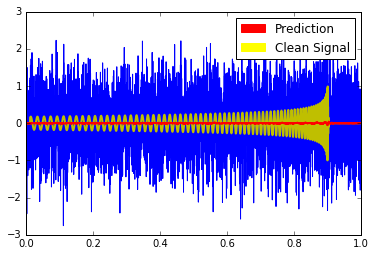

('MSE: ', 20.245597786749524)


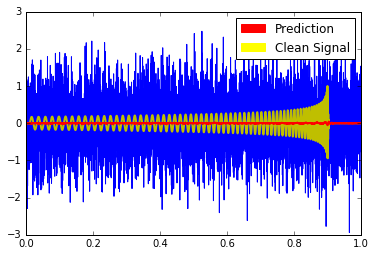

('MSE: ', 0.30354339666702573)


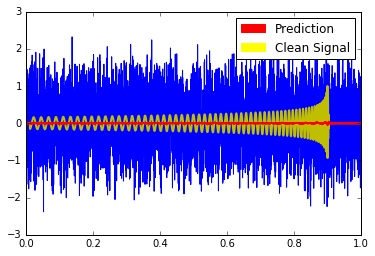

('MSE: ', 4.7313956313437151)


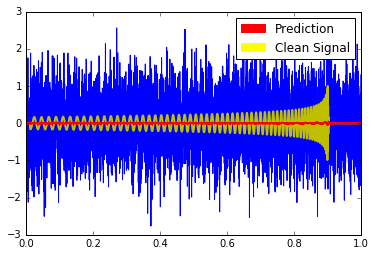

('MSE: ', 18.949206881099485)


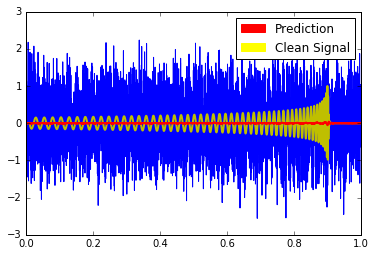

In [9]:
print("A Sample of the Results:")

n = 3
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t, x_test[n], "b-", label='Noisy Signal')
plt.plot(t, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 4
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t, x_test[n], "b-", label='Noisy Signal')
plt.plot(t, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 7
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t, x_test[n], "b-", label='Noisy Signal')
plt.plot(t, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 6
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t, x_test[n], "b-", label='Noisy Signal')
plt.plot(t, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 13
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t, x_test[n], "b-", label='Noisy Signal')
plt.plot(t, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()